<div class ="alert alert-block alert-warning">
    
- This notebook aims to apply AutoGluon-TimeSeries as covered by https://paperswithcode.com/paper/autogluon-timeseries-automl-for-probabilistic on the M5 dataset

- we aim to deploy it and run on the validation set having successfully implemented on 1 time-series in https://www.kaggle.com/code/yorkyong/m5-forecasting-autogluon-1series

# Import Libraries

In [1]:
pip install autogluon thinc==8.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of spacy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to de

In [2]:
import gc
import os
import psutil

import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import warnings  # To suppress warnings
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

import random  # For generating random numbers

# Function to set a fixed random seed for reproducibility
def seed_everything(seed):
    np.random.seed(seed)  # Set numpy random seed
    random.seed(seed)  # Set built-in random seed

seed_everything(seed=2024)  # Set the seed to 2024


# Load Dataset

In [3]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")  # Load calendar dataset
print(f"len(calendar):{len(calendar)}")  # Print the number of rows in calendar
calendar

len(calendar):1969


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
sales_train_evaluation = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
print(f"len(sales_train_evaluation): {len(sales_train_evaluation)}")
sales_train_evaluation.head()

len(sales_train_evaluation): 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
print(f"len(sell_prices):{len(sell_prices)}")
sell_prices

len(sell_prices):6841121


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
# Enhanced memory optimization function with object datatype handling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # Initial memory usage in MB
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:  # Downcast numerics
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        elif col_type == 'object':  # Handle object types
            if col == 'date':  # Convert date column to datetime
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            else:
                df[col] = df[col].astype('category')  # Convert other object types to category
    end_mem = df.memory_usage().sum() / 1024**2  # Final memory usage in MB
    if verbose:
        print(f'Memory usage reduced to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [7]:
# Apply the optimized memory reduction function to each dataframe
calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
sales_train_evaluation = reduce_mem_usage(sales_train_evaluation)

Memory usage reduced to  0.13 Mb (40.4% reduction)
Memory usage reduced to 45.76 Mb (78.1% reduction)
Memory usage reduced to 96.30 Mb (78.7% reduction)


# Convert Sales Data to Long format

In [8]:
# Specify day columns up to d_1941 for the extended dataset
d_cols_eval = [f"d_{i}" for i in range(1, 1942)]
sales_train_evaluation_long = sales_train_evaluation.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    value_vars=d_cols_eval,
    var_name="d",
    value_name="sales"
)
print(f"len(sales_train_evaluation_long): {len(sales_train_evaluation_long)}")
sales_train_evaluation_long.head()

len(sales_train_evaluation_long): 59181090


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


# Label Endcode Calendar event

In [9]:
# Encode event-related features in the calendar dataframe
event_columns = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
le = LabelEncoder()
for col in event_columns:
    calendar[col] = le.fit_transform(calendar[col].astype(str))

# Merge with Calender data

In [10]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(calendar, on="d", how="left")
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0


# Merge with Price data

In [11]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(
    sell_prices, 
    on=["store_id", "item_id", "wm_yr_wk"], 
    how="left"
)
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN


# Define Train, Validation and Evaluation sets

In [12]:
train_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1500, 1914)])]
print("Train set sample:")
print(f"len(Train set): {len(train_set)}")
train_set.head()

Train set sample:
len(Train set): 12622860


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
45704510,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,8.257812
45704511,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,3.970703
45704512,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.970703
45704513,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,10,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,4.640625
45704514,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,2,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.880859


In [13]:
# Filter the validation set for d_1914 to d_1941
validation_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1914, 1942)])]
print("Validation set sample:")
print(f"len(Validation set): {len(validation_set)}")
validation_set.head()


Validation set sample:
len(Validation set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859


In [14]:
# Create a new DataFrame for the prediction period (d_1942 to d_1969)
forecast_days = [f'd_{i}' for i in range(1942, 1970)]
forecast_df = pd.DataFrame({'d': forecast_days})

# Generate one entry per product-store combination for each forecast day
prediction_set = sales_train_evaluation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
prediction_set = prediction_set.merge(forecast_df, how='cross')

# Merge with calendar data to add date information for the forecast period
prediction_set = prediction_set.merge(calendar, on='d', how='left')

# Merge with sell_prices to add price data, aligning with the correct store, item, and week
prediction_set = prediction_set.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

print("Prediction set sample:")
print(f"len(Prediction set): {len(prediction_set)}")
prediction_set.head()


Prediction set sample:
len(Prediction set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812


In [15]:
# Apply the optimized memory reduction function to each dataframe
train_set = reduce_mem_usage(train_set)
validation_set = reduce_mem_usage(validation_set)
prediction_set = reduce_mem_usage(prediction_set)

Memory usage reduced to 531.02 Mb (43.5% reduction)
Memory usage reduced to 36.34 Mb (44.0% reduction)
Memory usage reduced to 28.20 Mb (50.3% reduction)


In [16]:
train_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
45704510,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,8.257812
45704511,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,3.970703
45704512,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.970703
45704513,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,10,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,4.640625
45704514,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,2,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,1.280273


In [17]:
validation_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.980469
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.480469
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,3.980469
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,1.280273


In [18]:
prediction_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1965,2016-06-15,11620,Wednesday,...,6,2016,30,4,4,2,0,1,1,1.000000
853716,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1966,2016-06-16,11620,Thursday,...,6,2016,30,4,4,2,0,0,0,1.000000
853717,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1967,2016-06-17,11620,Friday,...,6,2016,30,4,4,2,0,0,0,1.000000
853718,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1968,2016-06-18,11621,Saturday,...,6,2016,30,4,4,2,0,0,0,1.000000


# Transform train_set into AutoGluon's TimeSeriesDataFrame

In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12622860 entries, 45704510 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(8), datetime64[ns](1), float16(1), int16(3), int8(

In [20]:
# Step 1: Convert the 'date' column to datetime format
train_set['date'] = pd.to_datetime(train_set['date'])

# Step 2: Select only the relevant columns for AutoGluon, including target and covariates
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
train_set_for_autogluon = train_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
train_set_for_autogluon = train_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame format, specifying id_column and timestamp_column
train_set_for_autogluon = TimeSeriesDataFrame.from_data_frame(
    df=train_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [21]:
train_set_for_autogluon = reduce_mem_usage(train_set_for_autogluon)

Memory usage reduced to 218.00 Mb (0.0% reduction)


In [22]:
train_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2015-03-08      FOODS_1     CA_1      1     2   
                                2015-03-09      FOODS_1     CA_1      0     3   
                                2015-03-10      FOODS_1     CA_1      1     4   
                                2015-03-11      FOODS_1     CA_1      0     5   
                                2015-03-12      FOODS_1     CA_1      1     6   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20  HOUSEHOLD_2     WI_3      0     5   
                                2016-04-21  HOUSEHOLD_2     WI_3      0     6   
                                2016-04-22  HOUSEHOLD_2     WI_3      0     7   
                                2016-04-23  HOUSEHOLD_2     WI_3      0     1   
                                2016-04-24  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2015-03-08        1        0        1   
                                2015-03-09        1        1        1   
                                2015-03-10        1        0        0   
                                2015-03-11        0        1        1   
                                2015-03-12        0        1        1   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20        0        0        0   
                                2016-04-21        0        0        0   
                                2016-04-22        0        0        0   
                                2016-04-23        0        0        0   
                                2016-04-24        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2015-03-08    2.240234            30   
                                2015-03-09    2.240234            30   
                                2015-03-10    2.240234            30   
                                2015-03-11    2.240234            30   
                                2015-03-12    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20    5.941406            30   
                                2016-04-21    5.941406            30   
                                2016-04-22    5.941406            30   
                                2016-04-23    5.941406            30   
                                2016-04-24    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2015-03-08             4             4   
                                2015-03-09             4             4   
                                2015-03-10             4             4   
                                2015-03-11             4             4   
                                2015-03-12             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20             4             4   
                                2016-04-21             4             4   
                                2016-04-22             4             4   
                                2016-04-23             4             4   
                                2016-04-24             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [23]:
# Check for missing values in each column of the DataFrame
missing_values = train_set_for_autogluon.isna().sum()

# Filter to show only columns with missing values
missing_values = missing_values[missing_values > 0]

# Display the missing values
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sell_price    55736
dtype: int64


In [24]:
# Filter rows where 'sales' is negative
negative_sales_rows = train_set_for_autogluon[train_set_for_autogluon['sales'] < 0]

# Display the rows with negative 'sales' values
print(negative_sales_rows)


Empty TimeSeriesDataFrame
Columns: [dept_id, store_id, sales, wday, snap_CA, snap_TX, snap_WI, sell_price, event_name_1, event_type_1, event_name_2, event_type_2]
Index: []


# TimeSeriesPredictor

In [34]:
# Step 1: Initialize the TimeSeriesPredictor with a primary eval_metric
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="sales",
    known_covariates_names=['dept_id', 'store_id','wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'event_name_1','event_type_1','event_name_2', 'event_type_2'] ,
    eval_metric="RMSSE"  # Primary metric for training
)

In [35]:
# Define custom lags
# custom_lags = list(range(28, 43))  # Lags from 28 to 42 days

# Define short-term, weekly and monthly lags
custom_lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 56, 84] 


# Define LightGBM parameters
lgbm_params = {
                    'boosting_type': 'gbdt',
#                     'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.015,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 3000,
                    'boost_from_average': False,
                    'verbose': -1,
                }

In [36]:
# Step 2: Fit the predictor with all models in the model zoo using default hyperparameters
predictor.fit(
    train_data=train_set_for_autogluon,
    hyperparameters={
        'DirectTabular': {
            'lags': custom_lags,
            'tabular_hyperparameters': {'GBM': lgbm_params},
        },
      
        'RecursiveTabular': {
            'lags': custom_lags,
            'tabular_hyperparameters': {'GBM': lgbm_params},
        },
        'Theta': {}

    }
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241107_125131'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       14.28 GB / 31.36 GB (45.6%)
Disk Space Avail:   16.09 GB / 19.52 GB (82.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSSE,
 'hyperparameters': {'DirectTabular': {'lags': [28,
                                                29,
                                                30,
                                                31,
                                                32,
                                                33,
                                                34,
                                                35,
                                                36,
    

# Predict for Validation set 

In [37]:
# Step 1: Ensure 'date' is in datetime format
validation_set['date'] = pd.to_datetime(validation_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
validation_set_for_autogluon = validation_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
validation_set_for_autogluon = validation_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
validation_set_for_autogluon = TimeSeriesDataFrame(
    data=validation_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [38]:
validation_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2016-04-25      FOODS_1     CA_1      2     3   
                                2016-04-26      FOODS_1     CA_1      0     4   
                                2016-04-27      FOODS_1     CA_1      0     5   
                                2016-04-28      FOODS_1     CA_1      0     6   
                                2016-04-29      FOODS_1     CA_1      0     7   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  HOUSEHOLD_2     WI_3      0     5   
                                2016-05-19  HOUSEHOLD_2     WI_3      0     6   
                                2016-05-20  HOUSEHOLD_2     WI_3      0     7   
                                2016-05-21  HOUSEHOLD_2     WI_3      0     1   
                                2016-05-22  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2016-04-25        0        0        0   
                                2016-04-26        0        0        0   
                                2016-04-27        0        0        0   
                                2016-04-28        0        0        0   
                                2016-04-29        0        0        0   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18        0        0        0   
                                2016-05-19        0        0        0   
                                2016-05-20        0        0        0   
                                2016-05-21        0        0        0   
                                2016-05-22        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2016-04-25    2.240234            30   
                                2016-04-26    2.240234            30   
                                2016-04-27    2.240234            30   
                                2016-04-28    2.240234            30   
                                2016-04-29    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18    5.941406            30   
                                2016-05-19    5.941406            30   
                                2016-05-20    5.941406            30   
                                2016-05-21    5.941406            30   
                                2016-05-22    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2016-04-25             4             4   
                                2016-04-26             4             4   
                                2016-04-27             4             4   
                                2016-04-28             4             4   
                                2016-04-29             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18             4             4   
                                2016-05-19             4             4   
                                2016-05-20             4             4   
                                2016-05-21             4             4   
                                2016-05-22             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [39]:
# Step 5: Make predictions using the validation set as known covariates

%time
validation_preds = predictor.predict(train_set_for_autogluon, known_covariates=validation_set_for_autogluon)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [40]:
validation_preds

mean       0.1       0.2  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  0.920016 -0.806106 -0.241933   
                                2016-04-26  0.851335 -1.403577 -0.636650   
                                2016-04-27  0.836943 -1.855359 -0.899107   
                                2016-04-28  0.808514 -2.139803 -1.131439   
                                2016-04-29  0.972422 -2.093377 -1.058453   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.074604 -0.776832 -0.484893   
                                2016-05-19  0.078128 -0.797027 -0.489403   
                                2016-05-20  0.085825 -0.832000 -0.513612   
                                2016-05-21  0.079016 -0.782502 -0.480849   
                                2016-05-22  0.085337 -0.834353 -0.529022   

                                                 0.3       0.4       0.5  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  0.167690  0.582513  0.946622   
                                2016-04-26 -0.087076  0.360759  0.762970   
                                2016-04-27 -0.246558  0.315854  0.813390   
                                2016-04-28 -0.435391  0.169310  0.721190   
                                2016-04-29 -0.280583  0.359121  0.950427   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18 -0.278881 -0.099300  0.063028   
                                2016-05-19 -0.254792 -0.044107  0.116447   
                                2016-05-20 -0.303729 -0.119999  0.060097   
                                2016-05-21 -0.278385 -0.104761  0.072951   
                                2016-05-22 -0.292914 -0.112514  0.081386   

                                                 0.6       0.7       0.8  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.321152  1.694503  2.123494   
                                2016-04-26  1.221809  1.686867  2.224525   
                                2016-04-27  1.288996  1.844847  2.478294   
                                2016-04-28  1.310905  1.906978  2.585147   
                                2016-04-29  1.540179  2.212680  3.035028   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.230016  0.414793  0.631799   
                                2016-05-19  0.268605  0.430537  0.648406   
                                2016-05-20  0.246724  0.429034  0.645934   
                                2016-05-21  0.254422  0.429778  0.654132   
                                2016-05-22  0.249532  0.442581  0.651415   

                                                 0.9  
item_id                         timestamp             
FOODS_1_001_CA_1_evaluation     2016-04-25  2.775060  
                                2016-04-26  2.949069  
                                2016-04-27  3.364609  
                                2016-04-28  3.591104  
                                2016-04-29  4.132324  
...                                              ...  
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.913159  
                                2016-05-19  0.937813  
                                2016-05-20  0.965124  
                                2016-05-21  0.943881  
                                2016-05-22  0.968654  

[853720 rows x 10 columns]

In [41]:
validation_preds.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 853720 entries, ('FOODS_1_001_CA_1_evaluation', Timestamp('2016-04-25 00:00:00')) to ('HOUSEHOLD_2_516_WI_3_evaluation', Timestamp('2016-05-22 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mean    853720 non-null  float64
 1   0.1     853720 non-null  float64
 2   0.2     853720 non-null  float64
 3   0.3     853720 non-null  float64
 4   0.4     853720 non-null  float64
 5   0.5     853720 non-null  float64
 6   0.6     853720 non-null  float64
 7   0.7     853720 non-null  float64
 8   0.8     853720 non-null  float64
 9   0.9     853720 non-null  float64
dtypes: float64(10)
memory usage: 68.9 MB


In [42]:
target_item_id = 'FOODS_3_586_TX_1_evaluation'

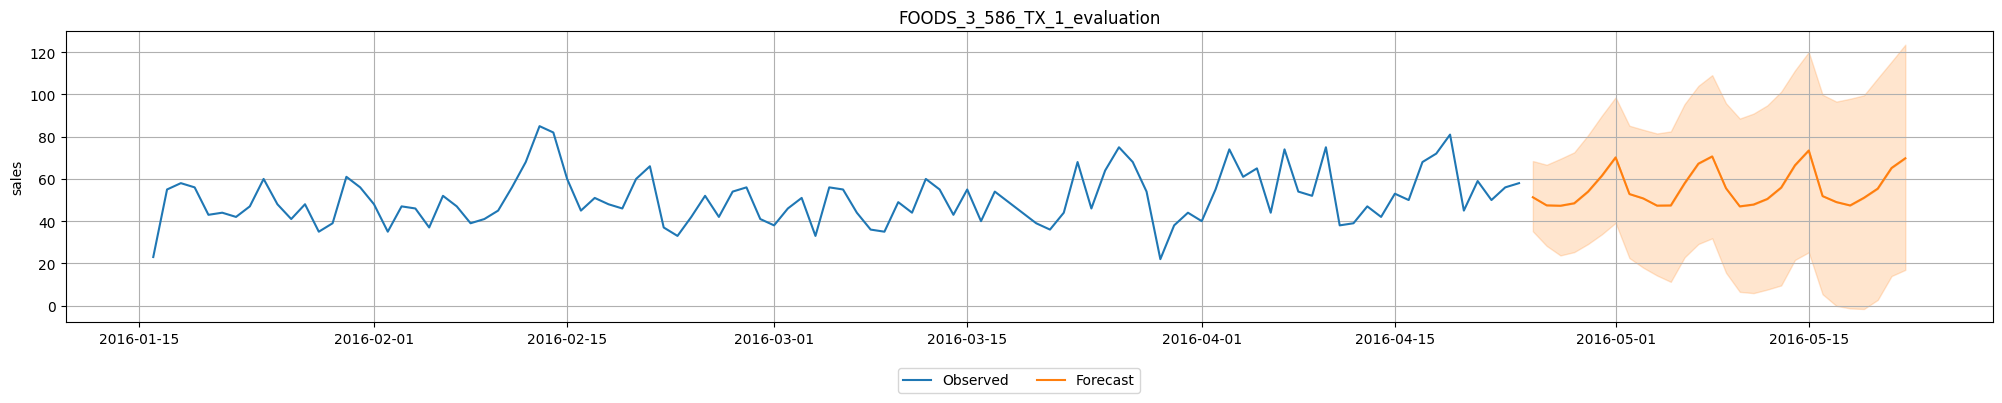

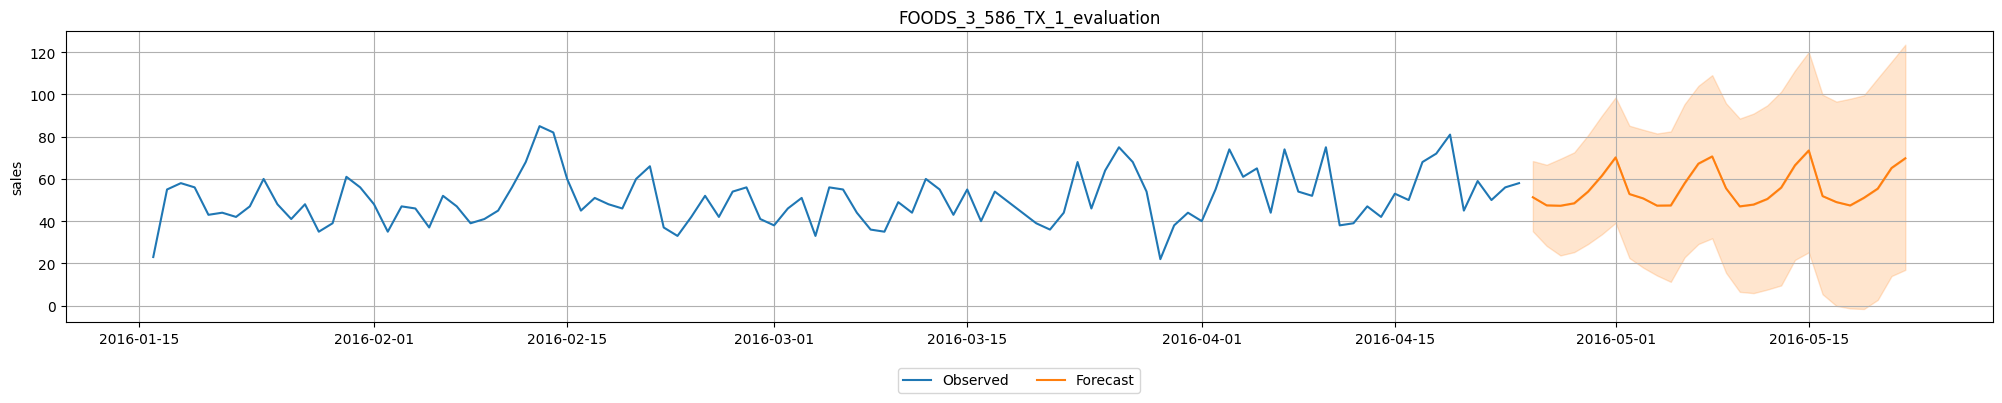

In [43]:
predictor.plot(
    data=train_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

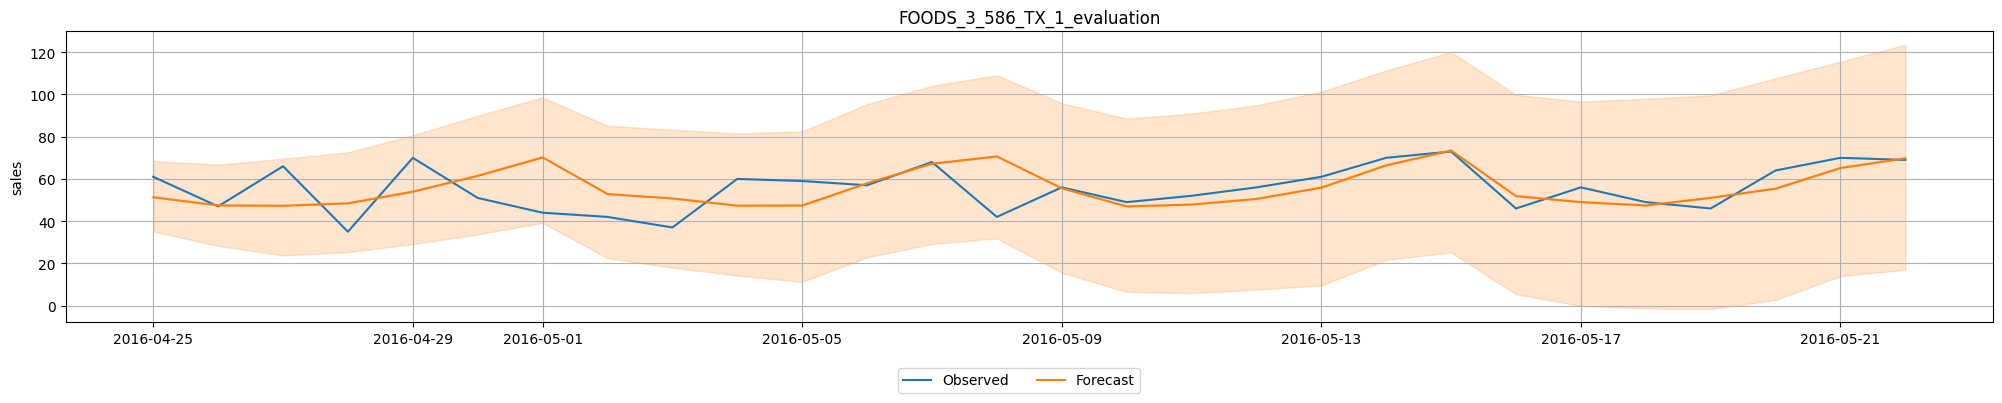

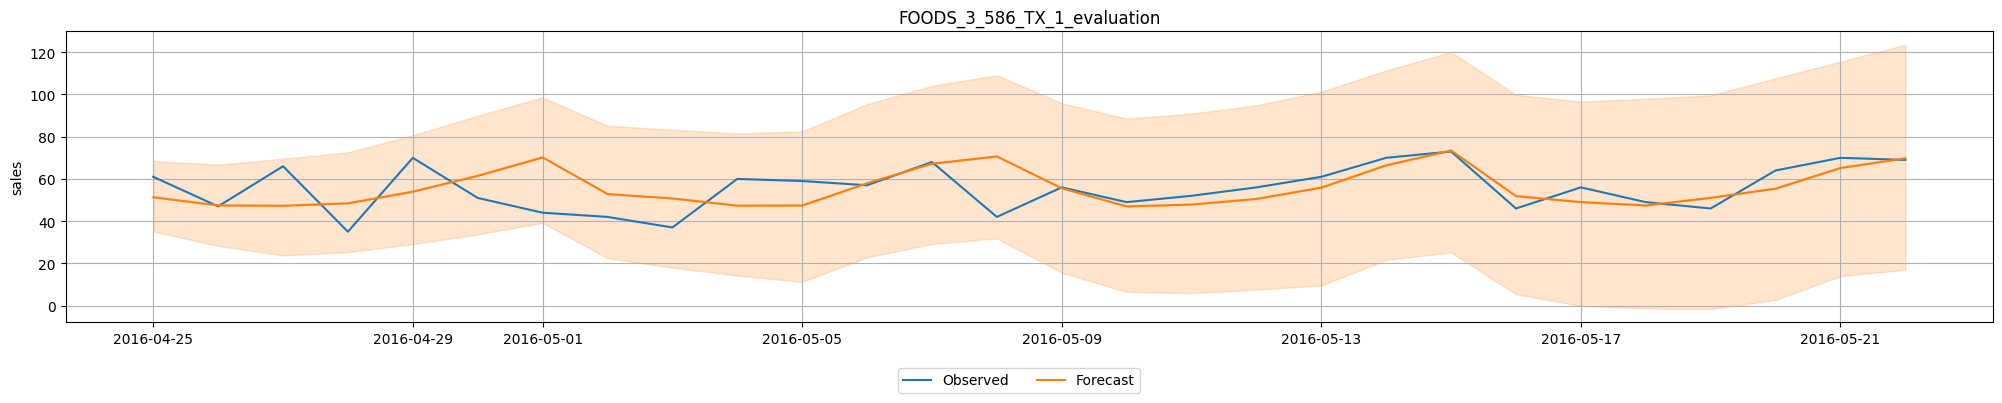

In [44]:
predictor.plot(
    data=validation_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=28 
)

In [45]:
# Step 1: Extract the mean predictions
mean_predictions = validation_preds['mean']

# Step 2: Reshape the data
mean_predictions = mean_predictions.reset_index()
mean_predictions['forecast_day'] = mean_predictions.groupby('item_id').cumcount() + 1
validation_df = mean_predictions.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
validation_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

# Step 4: Modify 'id' for submission
validation_df['id'] = validation_df['id'].str.replace('evaluation', 'validation')


In [46]:
validation_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.920016,0.851335,0.836943,0.808514,0.972422,0.988604,0.972024,0.953047,0.931450,...,0.933251,0.958149,0.943397,0.965095,0.876173,0.912257,0.836162,0.980258,0.977327,0.977205
1,FOODS_1_001_CA_2_validation,1.200703,1.238149,1.294070,1.332137,1.367194,1.390325,1.504587,1.215076,1.307340,...,1.376123,1.479001,1.681530,1.306029,1.333398,1.318697,1.536628,1.398905,1.631222,1.602361
2,FOODS_1_001_CA_3_validation,1.124986,1.111458,1.195276,1.018570,1.061924,1.145838,1.125987,1.005142,1.016769,...,1.253333,1.257889,1.363278,1.129730,1.167955,1.026600,1.247371,1.125748,1.134708,1.185989
3,FOODS_1_001_CA_4_validation,0.441192,0.345650,0.339947,0.342329,0.411101,0.381393,0.379084,0.396225,0.336262,...,0.381635,0.371804,0.346574,0.421867,0.346882,0.338716,0.350399,0.426741,0.428843,0.455279
4,FOODS_1_001_TX_1_validation,0.305535,0.281346,0.253546,0.275385,0.273102,0.281738,0.310959,0.286210,0.326574,...,0.388549,0.365956,0.388220,0.292274,0.289760,0.317057,0.337184,0.352620,0.334824,0.388017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.353482,0.327144,0.303075,0.329599,0.358806,0.360493,0.365915,0.347380,0.297607,...,0.396866,0.400613,0.399847,0.368900,0.326793,0.360390,0.345393,0.354002,0.358348,0.384480
30486,HOUSEHOLD_2_516_TX_3_validation,0.141468,0.140733,0.140289,0.159719,0.184336,0.166409,0.152988,0.130740,0.140884,...,0.210944,0.166476,0.162551,0.151371,0.145806,0.168257,0.137002,0.166050,0.151085,0.175058
30487,HOUSEHOLD_2_516_WI_1_validation,0.062630,0.062401,0.058703,0.062501,0.082171,0.071055,0.065717,0.060584,0.057378,...,0.069702,0.082862,0.084348,0.061516,0.066860,0.061544,0.070549,0.077109,0.078930,0.075644
30488,HOUSEHOLD_2_516_WI_2_validation,0.074527,0.074148,0.070354,0.103557,0.087989,0.077219,0.075850,0.077814,0.076829,...,0.090568,0.086453,0.083553,0.079502,0.079853,0.079097,0.101959,0.083304,0.086716,0.081779


# Predict for Prediction set

In [47]:
# Step 1: Ensure 'date' is in datetime format
prediction_set['date'] = pd.to_datetime(prediction_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
prediction_set_for_autogluon = prediction_set[['id', 'date'] + covariate_columns].copy()

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
prediction_set_for_autogluon = TimeSeriesDataFrame(
    data=prediction_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [48]:
# Concatenate the training and validation sets
combined_df = pd.concat([train_set_for_autogluon, validation_set_for_autogluon])

# Convert the concatenated DataFrame back to a TimeSeriesDataFrame
combined_tsdf = TimeSeriesDataFrame(combined_df)

In [49]:
%time
# Step 4: Make predictions using the prediction set as known covariates
prediction_preds = predictor.predict(combined_tsdf, known_covariates=prediction_set_for_autogluon)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


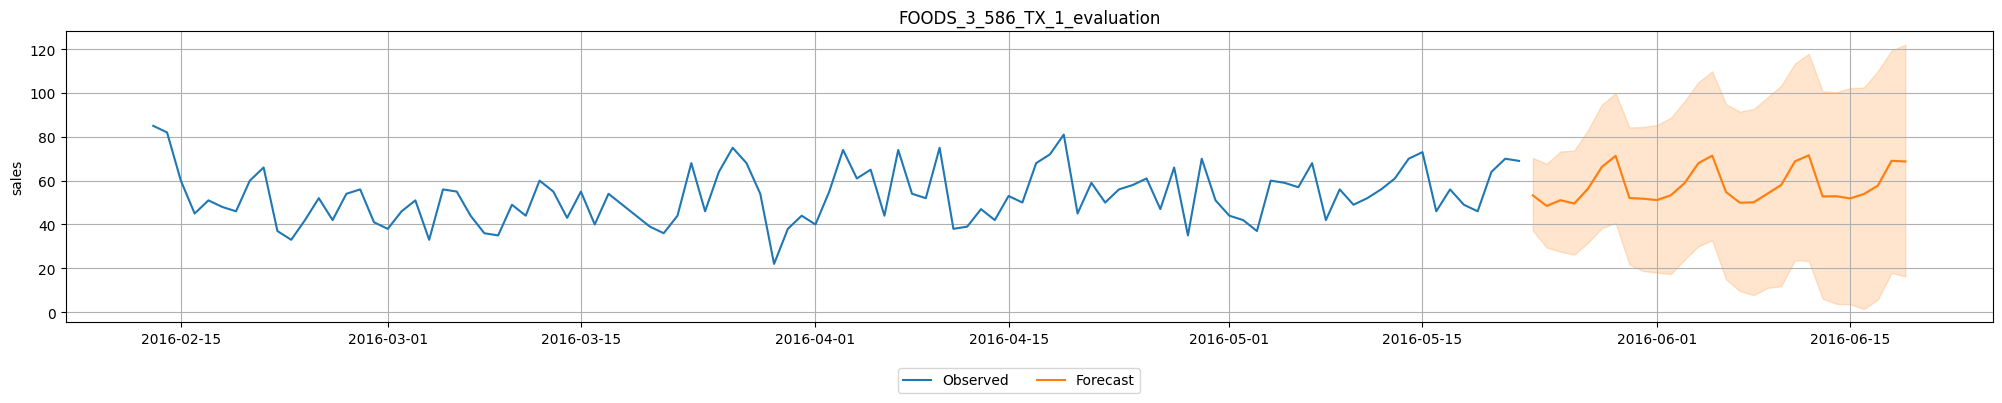

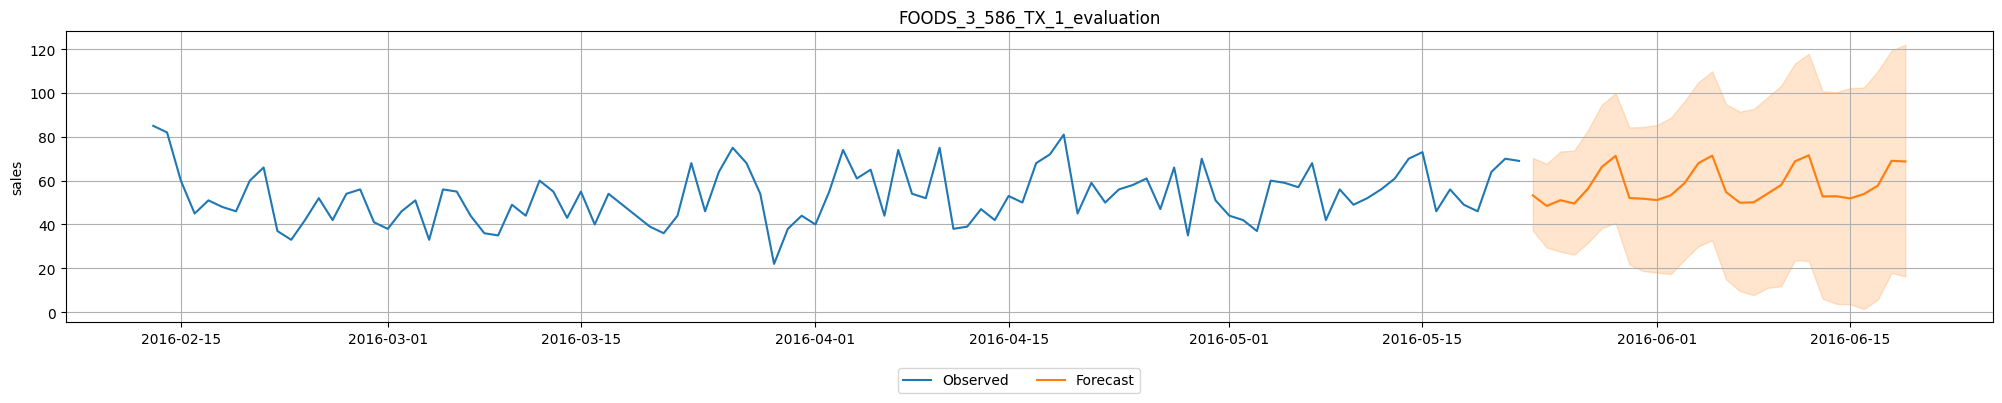

In [50]:
predictor.plot(
    data=combined_tsdf,
    predictions=prediction_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

In [51]:
# Step 1: Extract the mean predictions
mean_predictions1 = prediction_preds['mean']

# Step 2: Reshape the data
mean_predictions1 = mean_predictions1.reset_index()
mean_predictions1['forecast_day'] = mean_predictions1.groupby('item_id').cumcount() + 1
prediction_df = mean_predictions1.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
prediction_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

In [52]:
prediction_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.635655,0.655327,0.601146,0.637482,0.732942,0.736020,0.718981,0.641061,0.729871,...,0.713258,0.828646,0.814926,0.668687,0.672480,0.605959,0.653445,0.789370,0.791560,0.677114
1,FOODS_1_001_CA_2_evaluation,0.912659,0.846152,0.801861,0.769509,0.877936,1.006897,1.023167,0.882929,0.853210,...,0.897549,1.040335,1.082663,0.895395,0.829332,0.763539,0.790304,0.875997,1.023035,0.886294
2,FOODS_1_001_CA_3_evaluation,1.184257,1.161713,1.226796,1.018626,1.304591,1.187029,1.310070,1.041624,1.245343,...,1.260159,1.230085,1.269342,1.117032,1.072835,1.094559,1.072873,1.281595,1.280917,1.336134
3,FOODS_1_001_CA_4_evaluation,0.267183,0.264105,0.287292,0.292974,0.248540,0.258106,0.286479,0.277181,0.266529,...,0.247999,0.266452,0.262330,0.254624,0.263439,0.294046,0.294453,0.267151,0.280789,0.271589
4,FOODS_1_001_TX_1_evaluation,0.947291,1.030247,0.936024,0.965236,1.009902,0.924363,1.060178,0.914085,1.049138,...,0.970581,1.039145,1.054825,0.959779,1.093230,0.944613,0.965661,1.007791,1.023680,1.067315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.329423,0.299081,0.293631,0.289400,0.309583,0.315290,0.358113,0.321099,0.321776,...,0.334859,0.318708,0.366906,0.319992,0.328158,0.340490,0.312967,0.355491,0.369937,0.395849
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.370907,0.366248,0.363207,0.372573,0.410294,0.394679,0.440715,0.369682,0.382419,...,0.365255,0.395887,0.437036,0.381476,0.390842,0.372965,0.387482,0.408576,0.418612,0.487486
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.124685,0.122314,0.127282,0.128357,0.161252,0.163649,0.139101,0.119844,0.120681,...,0.170140,0.142999,0.132021,0.122328,0.125722,0.124507,0.126994,0.163717,0.152320,0.153976
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.123726,0.097495,0.096444,0.096868,0.101894,0.096070,0.101376,0.115891,0.093982,...,0.108689,0.105167,0.102363,0.119955,0.099688,0.095904,0.100623,0.109902,0.113355,0.104020


# For Submission

In [53]:
# Combine validation and evaluation for submission
submit = pd.concat([validation_df, prediction_df]).reset_index(drop=True)
submit.to_csv('submission.csv', index=False)

In [54]:
submit.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.920016,0.851335,0.836943,0.808514,0.972422,0.988604,0.972024,0.953047,0.931450,...,0.933251,0.958149,0.943397,0.965095,0.876173,0.912257,0.836162,0.980258,0.977327,0.977205
1,FOODS_1_001_CA_2_validation,1.200703,1.238149,1.294070,1.332137,1.367194,1.390325,1.504587,1.215076,1.307340,...,1.376123,1.479001,1.681530,1.306029,1.333398,1.318697,1.536628,1.398905,1.631222,1.602361
2,FOODS_1_001_CA_3_validation,1.124986,1.111458,1.195276,1.018570,1.061924,1.145838,1.125987,1.005142,1.016769,...,1.253333,1.257889,1.363278,1.129730,1.167955,1.026600,1.247371,1.125748,1.134708,1.185989
3,FOODS_1_001_CA_4_validation,0.441192,0.345650,0.339947,0.342329,0.411101,0.381393,0.379084,0.396225,0.336262,...,0.381635,0.371804,0.346574,0.421867,0.346882,0.338716,0.350399,0.426741,0.428843,0.455279
4,FOODS_1_001_TX_1_validation,0.305535,0.281346,0.253546,0.275385,0.273102,0.281738,0.310959,0.286210,0.326574,...,0.388549,0.365956,0.388220,0.292274,0.289760,0.317057,0.337184,0.352620,0.334824,0.388017
5,FOODS_1_001_TX_2_validation,0.460338,0.453252,0.468954,0.496922,0.513519,0.509282,0.493371,0.446211,0.448333,...,0.575202,0.586712,0.577916,0.529167,0.511882,0.454122,0.501599,0.504521,0.518377,0.483834
6,FOODS_1_001_TX_3_validation,0.465591,0.442397,0.442367,0.499311,0.441952,0.475476,0.502340,0.454039,0.418335,...,0.440757,0.457193,0.479375,0.445077,0.427026,0.433261,0.474967,0.441948,0.451997,0.479212
7,FOODS_1_001_WI_1_validation,0.743929,0.812886,0.692714,0.764911,0.768388,0.984799,0.769845,0.716760,0.757561,...,0.803250,0.997807,0.806832,0.702051,0.768433,0.689065,0.759263,0.754483,1.051570,0.840284
8,FOODS_1_001_WI_2_validation,0.337515,0.339894,0.325675,0.320100,0.377974,0.331201,0.325503,0.311634,0.355033,...,0.338204,0.330447,0.375169,0.307159,0.373296,0.357548,0.335856,0.328757,0.325628,0.308948
9,FOODS_1_001_WI_3_validation,0.351640,0.348056,0.352762,0.334915,0.345986,0.500992,0.325856,0.365683,0.340169,...,0.337266,0.503672,0.339651,0.346483,0.352522,0.341423,0.317397,0.329018,0.510490,0.342471


In [55]:
submit.tail(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60970,HOUSEHOLD_2_516_CA_1_evaluation,0.231648,0.213280,0.189366,0.194990,0.218547,0.258443,0.274847,0.217004,0.219104,...,0.292522,0.248477,0.245883,0.208907,0.210734,0.177817,0.227575,0.248288,0.305647,0.285703
60971,HOUSEHOLD_2_516_CA_2_evaluation,0.415680,0.404173,0.425845,0.434228,0.408104,0.546336,0.499788,0.422292,0.423344,...,0.422590,0.524323,0.451045,0.401429,0.389921,0.416405,0.434030,0.428657,0.546164,0.486339
60972,HOUSEHOLD_2_516_CA_3_evaluation,0.177692,0.181718,0.131104,0.185636,0.147060,0.181038,0.128259,0.168771,0.186963,...,0.159513,0.176689,0.134043,0.169412,0.187969,0.140605,0.188896,0.152149,0.176108,0.126459
60973,HOUSEHOLD_2_516_CA_4_evaluation,0.129656,0.117261,0.117831,0.130943,0.140235,0.151226,0.136444,0.133192,0.132230,...,0.134183,0.133120,0.131990,0.123675,0.135382,0.123407,0.151636,0.161157,0.154829,0.135495
60974,HOUSEHOLD_2_516_TX_1_evaluation,0.054681,0.050161,0.052963,0.054234,0.063783,0.058932,0.061238,0.047905,0.052108,...,0.062137,0.057336,0.059377,0.058750,0.056376,0.049858,0.061654,0.069564,0.069113,0.063706
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.329423,0.299081,0.293631,0.289400,0.309583,0.315290,0.358113,0.321099,0.321776,...,0.334859,0.318708,0.366906,0.319992,0.328158,0.340490,0.312967,0.355491,0.369937,0.395849
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.370907,0.366248,0.363207,0.372573,0.410294,0.394679,0.440715,0.369682,0.382419,...,0.365255,0.395887,0.437036,0.381476,0.390842,0.372965,0.387482,0.408576,0.418612,0.487486
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.124685,0.122314,0.127282,0.128357,0.161252,0.163649,0.139101,0.119844,0.120681,...,0.170140,0.142999,0.132021,0.122328,0.125722,0.124507,0.126994,0.163717,0.152320,0.153976
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.123726,0.097495,0.096444,0.096868,0.101894,0.096070,0.101376,0.115891,0.093982,...,0.108689,0.105167,0.102363,0.119955,0.099688,0.095904,0.100623,0.109902,0.113355,0.104020
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.094352,0.092363,0.090290,0.093770,0.090069,0.097134,0.108601,0.084491,0.091069,...,0.095475,0.089971,0.095080,0.093238,0.084453,0.087923,0.089516,0.108634,0.094824,0.092167
